In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # charts plotting
import plotly.graph_objects as go # more customized plotting
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
pd.set_option("display.max_columns", None)

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

In [ ]:
def feature_engineering(df):
  """
  This is the feature engineering function for the online retail dataset.
  It does feature cleanup, encoding, engineering and scaling
  """
  df = df[~df['InvoiceNo'].str.contains('C', na=False)]
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
  df = remove_outliers_iqr(df, 'UnitPrice')

  df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek
  # Monday=0, Sunday=6
  df['IsWeekend'] = df['InvoiceDayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

  # Week of Year
  df['WeekOfYear'] = df['InvoiceDate'].dt.isocalendar().week

  # Month
  df['Month'] = df['InvoiceDate'].dt.month

  df['ProductSaleFrequency'] = df.groupby('StockCode')['Quantity'].transform('count')
  # This is how many times a particular product was invoiced by different customers

  # Create customer-based features
  df['CustomerOrderCount'] = df.groupby('CustomerID')['InvoiceNo'].transform('count')
  # This is how many times a customer ordered through this online store

  # Customer Recency - Hpw recently did a customer make a transaction at the online store
  max_date = df['InvoiceDate'].max()
  latest_date = dt.datetime(max_date.year, max_date.month, max_date.day)

  recency = (latest_date - df.groupby("Customer ID").agg({"InvoiceDate":"max"}))
  recency.rename(columns = {"InvoiceDate":"Customer_Recency"}, inplace = True)
  # Change the values to day format
  recency_df = recency["Customer_Recency"].apply(lambda x: x.days).reset_index()
  df = pd.merge(df, recency_df, on='Customer ID', how='left')

  df['month_num'] = df['Month'].apply(lambda x: (x - 1) % 12 + 1)

  # Apply sine and cosine transformation
  df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
  df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

  # Target Encoding for Each Stockcode
  # Calculate the mean of 'Quantity' for each 'StockCode'

  stockcode_target_encoding = df.groupby('StockCode')['Quantity'].mean()

  # # Merge the target encoding back into the main DataFrame
  df['StockCode_TargetEncoded'] = df['StockCode'].map(stockcode_target_encoding)
  # df.head()
  num_feat = [ 'UnitPrice', 'ProductSaleFrequency',
              'CustomerOrderCount','Customer_Recency'
            ]
  df_num = df[num_feat]
  with open('/content/drive/MyDrive/Spinmaster/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

  scaled_features = scaler.transform(df_num)
  df_scaled_features = pd.DataFrame(scaled_features, columns=num_feat)

  other_feat = [ 'IsWeekend', "month_sin",
              "month_cos", 'StockCode_TargetEncoded']
  df_other_feat = df[other_feat + ['Quantity']]
  df_final = pd.concat([df_scaled_features, df_other_feat], axis=1)
  return df_final

In [ ]:
df_val_raw = pd.read_csv('/content/drive/MyDrive/Spinmaster/val_data.csv')
df_val = feature_engineering(df_val_raw)
print(df_val.shape)
df_val.head()

(2907, 9)


<ipython-input-13-caae4b0cc4a6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


,UnitPrice,ProductSaleFrequency,CustomerOrderCount,Customer_Recency,IsWeekend,month_sin,month_cos,StockCode_TargetEncoded,Quantity
0,0.509564,-1.929317,-0.508659,-0.619490,1,-0.866025,0.5,16.303797,48
1,1.378127,-1.699353,-0.511533,-0.073710,1,-0.866025,0.5,9.164894,15
2,-0.305989,-1.598084,-0.506743,-0.498205,1,-0.866025,0.5,11.800847,2
3,0.224120,-1.688804,-0.506743,-0.498205,1,-0.866025,0.5,6.616580,3
4,-0.305989,-1.610743,-0.509617,-0.073710,1,-0.866025,0.5,13.239130,2


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Spinmaster/train_data_preprocessed.csv')
print(df_train.shape)
df_train.head()

(13301, 9)


,UnitPrice,ProductSaleFrequency,CustomerOrderCount,Customer_Recency,IsWeekend,month_sin,month_cos,StockCode_TargetEncoded,Quantity
0,-0.469099,1.530699,-0.496207,3.898352,0,-2.449294e-16,1.0,19.267016,6
1,-0.819787,0.051753,-0.506743,0.881404,0,-2.449294e-16,1.0,24.307466,32
2,-0.469099,-1.195119,-0.510575,-0.301118,0,-2.449294e-16,1.0,12.845433,80
3,-0.469099,1.530699,-0.496207,3.898352,0,-2.449294e-16,1.0,19.267016,6
4,-0.102101,-1.608633,-0.508659,0.987528,0,-2.449294e-16,1.0,9.558442,48


In [ ]:
X_train = df_train.drop('Quantity', axis=1)
y_train = df_train['Quantity']
X_val = df_val.drop('Quantity', axis=1)
y_val = df_val['Quantity']

Decision Tree - Mean Squared Error: 69682.07673886126
Decision Tree - R-squared: -9.549967482243256
Decision Tree - Mean Absolute Error: 125.21909427288685


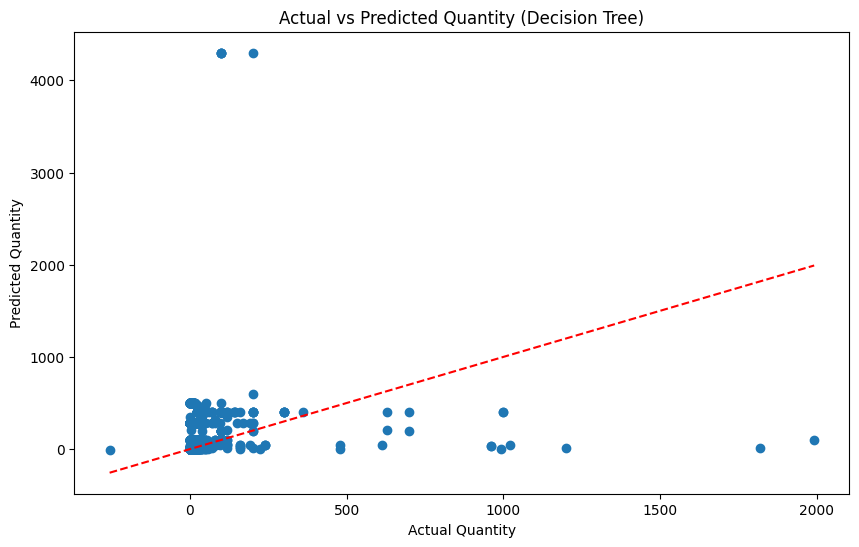

In [ ]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42) # You can tune hyperparameters here
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_val)

mse_tree = mean_squared_error(y_val, y_pred_tree)
r2_tree = r2_score(y_val, y_pred_tree)
mae_tree = mean_absolute_error(y_val, y_pred_tree)

print(f"Decision Tree - Mean Squared Error: {mse_tree}")
print(f"Decision Tree - R-squared: {r2_tree}")
print(f"Decision Tree - Mean Absolute Error: {mae_tree}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_tree)
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Actual vs Predicted Quantity (Decision Tree)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.show()

Best hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: -5566.167579612769
Decision Tree - Mean Squared Error: 8173.477909015584
Decision Tree - R-squared: -0.23747640989663732
Decision Tree - Mean Absolute Error: 26.743796837162773


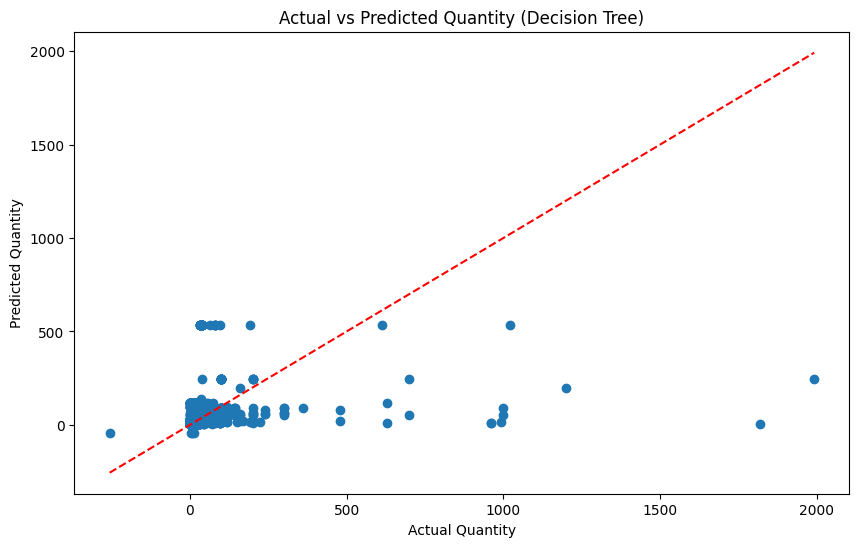

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Create a DecisionTreeRegressor object
tree_model = DecisionTreeRegressor(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the best model on the validation set
best_tree_model = grid_search.best_estimator_
y_pred_tree = best_tree_model.predict(X_val)

mse_tree = mean_squared_error(y_val, y_pred_tree)
r2_tree = r2_score(y_val, y_pred_tree)
mae_tree = mean_absolute_error(y_val, y_pred_tree)

print(f"Decision Tree - Mean Squared Error: {mse_tree}")
print(f"Decision Tree - R-squared: {r2_tree}")
print(f"Decision Tree - Mean Absolute Error: {mae_tree}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_tree)
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Actual vs Predicted Quantity (Decision Tree)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.show()

In [ ]:
# Base Model
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

# Define features (X) and target (y)
X_train = df_train.drop('Quantity', axis=1)
y_train = df_train['Quantity']
X_val = df_val.drop('Quantity', axis=1)
y_val = df_val['Quantity']

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # For regression
    'eval_metric': 'rmse',
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'eval')])


# Make predictions
y_pred = model.predict(dval)

# Calculate R-squared and MAE
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"R-squared: {r2}")
print(f"MAE: {mae}")

[0]	eval-rmse:80.76348
[1]	eval-rmse:80.73089
[2]	eval-rmse:80.70784
[3]	eval-rmse:80.28565
[4]	eval-rmse:80.59771
[5]	eval-rmse:80.57377
[6]	eval-rmse:80.29310
[7]	eval-rmse:80.53168
[8]	eval-rmse:80.34053
[9]	eval-rmse:80.24849
[10]	eval-rmse:80.88258
[11]	eval-rmse:82.99842
[12]	eval-rmse:83.25267
[13]	eval-rmse:85.23140
[14]	eval-rmse:85.25427
[15]	eval-rmse:85.23921
[16]	eval-rmse:85.28069
[17]	eval-rmse:85.27795
[18]	eval-rmse:84.89672
[19]	eval-rmse:84.88150
[20]	eval-rmse:86.77247
[21]	eval-rmse:86.62879
[22]	eval-rmse:86.63776
[23]	eval-rmse:87.03678
[24]	eval-rmse:87.05974
[25]	eval-rmse:86.64907
[26]	eval-rmse:88.42401
[27]	eval-rmse:88.35446
[28]	eval-rmse:90.28841
[29]	eval-rmse:90.25659
[30]	eval-rmse:89.93087
[31]	eval-rmse:91.55101
[32]	eval-rmse:93.34471
[33]	eval-rmse:93.35368
[34]	eval-rmse:93.33425
[35]	eval-rmse:93.37608
[36]	eval-rmse:93.33693
[37]	eval-rmse:93.21501
[38]	eval-rmse:93.30514
[39]	eval-rmse:95.14905
[40]	eval-rmse:95.14762
[41]	eval-rmse:95.14328
[4

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', seed=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_xgb_model.predict(X_val)
r2_best = r2_score(y_val, y_pred_best)
mae_best = mean_absolute_error(y_val, y_pred_best)

print(f"Best Model R-squared: {r2_best}")
print(f"Best Model MAE: {mae_best}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'colsample_bytree': 0.9, 'eta': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.9}
Best MAE: 13.11237875620524
Best Model R-squared: -0.8465100526809692
Best Model MAE: 30.8707218170166


In [ ]:
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))
print(f"Best Model RMSE: {rmse_best}")

Best Model RMSE: 110.43603652822071


MLP - Mean Squared Error: 8157.18397474982
MLP - R-squared: -0.2350094846167574
MLP - Mean Absolute Error: 47.14086662023198


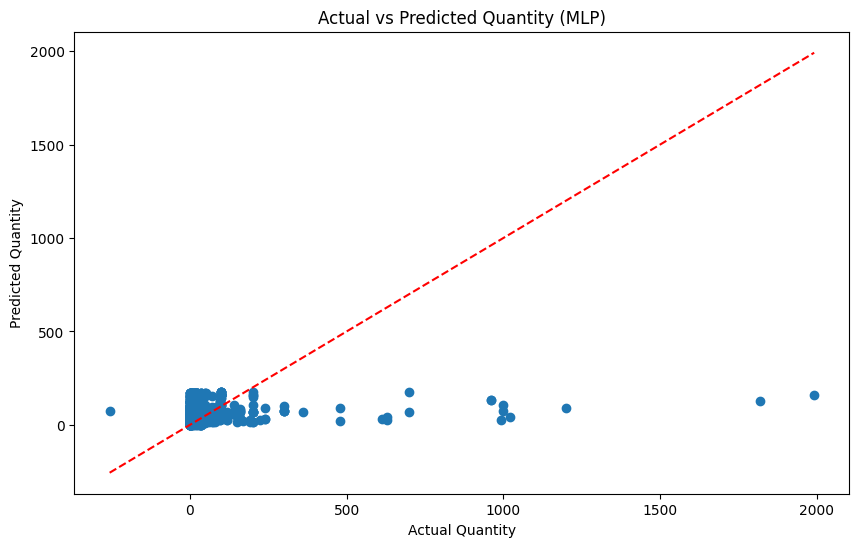

In [ ]:
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50),  # Adjust the number of neurons and layers
                         activation='relu',  # Activation function
                         solver='adam',  # Optimization algorithm
                         max_iter=500,  # Maximum number of iterations
                         random_state=42)

# Train the MLP model
mlp_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_mlp = mlp_model.predict(X_val)

# Evaluate the MLP model
mse_mlp = mean_squared_error(y_val, y_pred_mlp)
r2_mlp = r2_score(y_val, y_pred_mlp)
mae_mlp = mean_absolute_error(y_val, y_pred_mlp)

print(f"MLP - Mean Squared Error: {mse_mlp}")
print(f"MLP - R-squared: {r2_mlp}")
print(f"MLP - Mean Absolute Error: {mae_mlp}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_mlp)
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Actual vs Predicted Quantity (MLP)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.show()
